In [1]:
#Build a regression model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
import pandas as pd

df_bike_stations = pd.read_csv("london_bike_stations.csv")
df_yelp_locations = pd.read_csv("london_uk_yelp.csv")

# Merge the DataFrames on the common column 'id'
df_model = pd.merge(df_bike_stations, df_yelp_locations, on='id', how='inner')

# Check if the 'Unnamed: 0' column exists before dropping it
if 'Unnamed: 0' in df_model.columns:
    df_model = df_model.drop(columns='Unnamed: 0')

# Check the information about the DataFrame
df_model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0_x                     0 non-null      int64  
 1   empty_slots                      0 non-null      int64  
 2   free_bikes                       0 non-null      int64  
 3   id                               0 non-null      object 
 4   latitude                         0 non-null      float64
 5   longitude                        0 non-null      float64
 6   name_x                           0 non-null      object 
 7   Unnamed: 0_y                     0 non-null      int64  
 8   alias                            0 non-null      object 
 9   name_y                           0 non-null      object 
 10  image_url                        0 non-null      object 
 11  is_closed                        0 non-null      bool   
 12  url                              0

In [4]:
# missing data
empty_slots = df_model.isnull().sum().sort_values(ascending=False)
free_bikes = (df_model.isnull().sum()/df_model.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([empty_slots, free_bikes], axis=1, keys=['empty_slots', 'free_bikes'])
missing_data.head(20)

,empty_slots,free_bikes
Unnamed: 0_x,0,NaN
location.city,0,NaN
distance,0,NaN
coordinates.latitude,0,NaN
coordinates.longitude,0,NaN
location.address1,0,NaN
location.address2,0,NaN
location.address3,0,NaN
location.zip_code,0,NaN
phone,0,NaN


In [5]:
# drop 5 columns with the biggest ratio of null values
to_drop = missing_data.head(5).index.tolist()
df_model.drop(to_drop, axis=1, inplace=True)

In [6]:
# extract the names of columns with missing values
cols_with_missing = missing_data[missing_data.free_bikes > 0].index.tolist()
# remove column names that are already removed from dataset
missing_cols = list(set(cols_with_missing) - set(to_drop))
# check the datatype
df_model.dtypes[missing_cols]

Series([], dtype: object)

In [7]:
num_cols_with_missing = df_model.dtypes[missing_cols][df_model.dtypes[missing_cols] == 'float'].index.tolist()
# create new variable with the information that it was missing
for cl in num_cols_with_missing:
    df_train[cl + "_missing_ind"] = 0
    df_train.loc[df_train[cl].isnull(), cl + "_missing_ind"] = 1

In [8]:
df_model["empty_slots"] = df_model["empty_slots"].fillna(df_model["empty_slots"].fillna(0))
df_model["free_bikes"] = df_model["free_bikes"].fillna(df_model["free_bikes"].fillna(0))


In [9]:
print(df_model.shape)

(0, 30)


In [10]:
df_model.dtypes

empty_slots                          int64
free_bikes                           int64
id                                  object
latitude                           float64
longitude                          float64
name_x                              object
Unnamed: 0_y                         int64
alias                               object
name_y                              object
image_url                           object
is_closed                             bool
url                                 object
review_count                         int64
categories                          object
rating                             float64
transactions                        object
price                               object
phone                              float64
display_phone                       object
location.address1                   object
location.address2                   object
location.address3                  float64
location.zip_code                   object
location.co

In [11]:
# check for duplicates for Id
idsUnique = len(set(df_model.id))
idsTotal = df_model.shape[0]
idsdupe = idsTotal - idsUnique
print(idsdupe)
# drop id col
df_model.drop(['id'],axis =1,inplace=True)

0


In [12]:
print(df_model.columns)


Index(['empty_slots', 'free_bikes', 'latitude', 'longitude', 'name_x',
       'Unnamed: 0_y', 'alias', 'name_y', 'image_url', 'is_closed', 'url',
       'review_count', 'categories', 'rating', 'transactions', 'price',
       'phone', 'display_phone', 'location.address1', 'location.address2',
       'location.address3', 'location.zip_code', 'location.country',
       'location.state', 'location.display_address',
       'attributes.business_temp_closed', 'attributes.menu_url',
       'attributes.open24_hours', 'attributes.waitlist_reservation'],
      dtype='object')


In [13]:
df_model.describe()

,empty_slots,free_bikes,latitude,longitude,Unnamed: 0_y,review_count,rating,phone,location.address3,attributes.business_temp_closed,attributes.open24_hours,attributes.waitlist_reservation
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

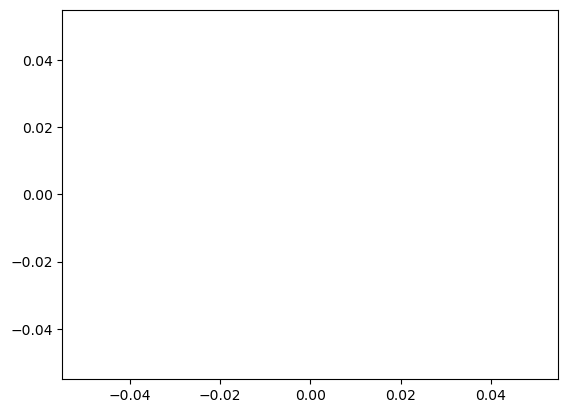

In [14]:
# descriptive statistics
df_model['free_bikes'].describe()
# histogram
sns.histplot(df_model['free_bikes'])

In [15]:
sns.pairplot(df_model) #Visualize pair of variables in the dataset via scatterplot.
plt.show()

In [16]:
#Formula to fit and print results of the linear regression model.
X = df_model[['yelp_rating', 'yelp_review_count', 'empty_slots']] # These are identified as independent variables
y = df_model['free_bikes'] # This is identified as the dependent variable

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

KeyError: "['yelp_rating', 'yelp_review_count'] not in index"